In [1]:
print("working")

working


In [32]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
DATASET_PATH = "../data/raw/public/emotion_dataset"

os.listdir(DATASET_PATH)


['EEG_data.csv', 'emotions.csv']

In [16]:
eeg_df = pd.read_csv(os.path.join(DATASET_PATH, "EEG_data.csv"))

emo_df = pd.read_csv(os.path.join(DATASET_PATH, "emotions.csv"))


In [14]:
eeg_df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [11]:
print(eeg_df.columns)
print(eeg_df.shape)
print(emo_df.columns)
print(emo_df.shape)

Index(['SubjectID', 'VideoID', 'Attention', 'Mediation', 'Raw', 'Delta',
       'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2',
       'predefinedlabel', 'user-definedlabeln'],
      dtype='object')
(12811, 15)
Index(['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a', 'mean_4_a',
       'mean_d_0_a', 'mean_d_1_a', 'mean_d_2_a', 'mean_d_3_a', 'mean_d_4_a',
       ...
       'fft_741_b', 'fft_742_b', 'fft_743_b', 'fft_744_b', 'fft_745_b',
       'fft_746_b', 'fft_747_b', 'fft_748_b', 'fft_749_b', 'label'],
      dtype='object', length=2549)
(2132, 2549)


In [13]:
for col in emo_df.columns:
    print(col, end = " ")

# mean_0_a mean_1_a mean_2_a mean_3_a mean_4_a mean_d_0_a mean_d_1_a mean_d_2_a mean_d_3_a mean_d_4_a mean_d_0_a2 mean_d_1_a2 mean_d_2_a2 mean_d_3_a2 mean_d_4_a2 mean_d_5_a mean_d_6_a mean_d_7_a mean_d_8_a mean_d_9_a mean_d_10_a mean_d_11_a mean_d_12_a mean_d_13_a mean_d_14_a mean_d_15_a mean_d_16_a mean_d_17_a mean_d_18_a mean_d_19_a mean_d_20_a mean_d_21_a mean_d_22_a mean_d_23_a mean_d_24_a mean_d_25_a mean_d_26_a mean_d_27_a mean_d_28_a mean_d_29_a mean_d_30_a mean_d_31_a mean_d_32_a mean_d_33_a mean_d_34_a mean_d_35_a mean_d_36_a mean_d_37_a mean_d_38_a mean_d_39_a mean_d_40_a mean_d_41_a mean_d_42_a mean_d_43_a mean_d_44_a mean_d_45_a mean_d_46_a mean_d_47_a mean_d_48_a mean_d_49_a stddev_0_a stddev_1_a stddev_2_a stddev_3_a stddev_4_a stddev_d_0_a stddev_d_1_a stddev_d_2_a stddev_d_3_a stddev_d_4_a moments_0_a moments_1_a moments_2_a moments_3_a moments_4_a moments_5_a moments_6_a moments_7_a moments_8_a moments_9_a moments_10_a moments_11_a moments_12_a moments_13_a moments_14_

In [17]:
BAND_MAPPING = {
    "delta": ["Delta"],
    "theta": ["Theta"],
    "alpha": ["Alpha1", "Alpha2"],
    "beta": ["Beta1", "Beta2"],
    "gamma": ["Gamma1", "Gamma2"],
    "raw": ["Raw"]
}

In [18]:
def extract_band(df, columns):
    """
    Extract a band by averaging available columns.
    """
    available_cols = [c for c in columns if c in df.columns]

    if len(available_cols) == 0:
        raise ValueError(f"Missing columns: {columns}")

    return df[available_cols].mean(axis=1)

In [22]:
# Z - Score Normalization
def normalize_feature(value, mean, std):
    return (value - mean) / (std + 1e-6)

# log transformation and relative scaling
def log_transform(value):
    return np.log(value + 1e-6)


In [50]:

def extract_features(df, band_mapping):
    """
    Extract standard EEG features from a single-channel dataframe.

    Returns: dict of features (fixed schema)
    """
    delta = extract_band(df, band_mapping["delta"])
    theta = extract_band(df, band_mapping["theta"])
    alpha = extract_band(df, band_mapping["alpha"])
    beta  = extract_band(df, band_mapping["beta"])
    gamma = extract_band(df, band_mapping["gamma"])

    # --- Log normalize band means ---
    delta_m = np.log(delta.mean() + 1e-6)
    theta_m = np.log(theta.mean() + 1e-6)
    alpha_m = np.log(alpha.mean() + 1e-6)
    beta_m  = np.log(beta.mean()  + 1e-6)
    gamma_m = np.log(gamma.mean() + 1e-6)

    features = {
        "delta_mean": delta_m,
        "theta_mean": theta_m,
        "alpha_mean": alpha_m,
        "beta_mean":  beta_m,
        "gamma_mean": gamma_m,
        "variance":   np.log(df[band_mapping["raw"][0]].var() + 1e-6),
        "beta_alpha_ratio": np.log((beta / (alpha + 1e-6)).mean() + 1e-6)
    }
    
    total_power = delta + theta + alpha + beta + gamma

    features.update({
        "theta_rel": (theta / (total_power + 1e-6)).mean(),
        "alpha_rel": (alpha / (total_power + 1e-6)).mean(),
        "beta_rel":  (beta  / (total_power + 1e-6)).mean(),
        "engagement_index": ((beta) / (alpha + theta + 1e-6)).mean()
    })


    return features



In [24]:
trial_df = eeg_df.groupby(["SubjectID", "VideoID"]).get_group((1, 1))

features = extract_features(trial_df, BAND_MAPPING)

features


{'delta_mean': np.float64(13.078723949335206),
 'theta_mean': np.float64(11.872183801476334),
 'alpha_mean': np.float64(10.251436933632265),
 'beta_mean': np.float64(9.719605341995681),
 'gamma_mean': np.float64(8.39351889286147),
 'variance': np.float64(9.176409824292623),
 'beta_alpha_ratio': np.float64(-0.2090051627646643)}

In [25]:
# features to ML ready vectors
FEATURE_ORDER = [
    "delta_mean",
    "theta_mean",
    "alpha_mean",
    "beta_mean",
    "gamma_mean",
    "variance",
    "beta_alpha_ratio"
]

def features_to_vector(feature_dict):
    return np.array([feature_dict[k] for k in FEATURE_ORDER])


In [ ]:
# X = []
# y = []

# for (sid, vid), group in eeg_df.groupby(["SubjectID", "VideoID"]):
#     feats = extract_features(group, BAND_MAPPING)
#     X.append(features_to_vector(feats))
#     y.append(group["predefinedlabel"].iloc[0])

# X = np.array(X)
# y = np.array(y)

# print(X.shape, y.shape)


(100, 7) (100,)


In [27]:
vec = features_to_vector(features)

print(vec)
print(vec.dtype)
print(vec.shape)

[13.07872395 11.8721838  10.25143693  9.71960534  8.39351889  9.17640982
 -0.20900516]
float64
(7,)


In [28]:
np.isnan(vec).any()

np.False_

In [29]:
vec.min(), vec.max()

(np.float64(-0.2090051627646643), np.float64(13.078723949335206))

In [30]:
all(len(features_to_vector(
    extract_features(g, BAND_MAPPING)
)) == 7 for _, g in eeg_df.groupby(["SubjectID","VideoID"]))


True

In [31]:
X = []
y = []

for (sid, vid), group in eeg_df.groupby(["SubjectID", "VideoID"]):
    feats = extract_features(group, BAND_MAPPING)
    vec = features_to_vector(feats)
    X.append(vec)
    y.append(group["predefinedlabel"].iloc[0])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("X dtype:", X.dtype)


X shape: (100, 7)
y shape: (100,)
X dtype: float64


In [33]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train, y_train)

y_pred = log_clf.predict(X_test)

print("Logistic Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Logistic Accuracy: 0.44
Confusion Matrix:
 [[ 3 10]
 [ 4  8]]


In [35]:
from sklearn.svm import SVC

svm_clf = SVC(kernel="linear")
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


SVM Accuracy: 0.44
Confusion Matrix:
 [[ 3 10]
 [ 4  8]]


In [36]:
theta = X[:, 1]                 # theta_mean
alpha = X[:, 2]                 # alpha_mean
beta  = X[:, 3]                 # beta_mean

stress_index_raw = (
    theta +
    (beta - alpha)
)


In [37]:
theta = X[:, 1]                 # theta_mean
alpha = X[:, 2]                 # alpha_mean
beta  = X[:, 3]                 # beta_mean

stress_index_raw = (
    theta +
    (beta - alpha)
)


In [38]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=1.0)
reg.fit(X_train, y_train)

stress_index_calibrated = reg.predict(X)


In [40]:
stress_index_calibrated = 1 + (
    stress_index_calibrated - stress_index_calibrated.min()
) / (
    stress_index_calibrated.max() - stress_index_calibrated.min()
)


In [41]:
print("RAW index mean (confused):",
      np.mean(stress_index_raw[y == 1]))
print("RAW index mean (not confused):",
      np.mean(stress_index_raw[y == 0]))

print("CALIBRATED index mean (confused):",
      np.mean(stress_index_calibrated[y == 1]))
print("CALIBRATED index mean (not confused):",
      np.mean(stress_index_calibrated[y == 0]))

RAW index mean (confused): 11.515164791714449
RAW index mean (not confused): 11.595548419332442
CALIBRATED index mean (confused): 1.5928388661415118
CALIBRATED index mean (not confused): 1.5179260186313344


In [42]:
(sample_sid, sample_vid), sample_df = list(
    eeg_df.groupby(["SubjectID", "VideoID"])
)[0]


In [43]:
WINDOW = 10  # 10 × 0.5s = 5 seconds
STEP = 2    # 1 second

theta_series = np.log(
    extract_band(sample_df, BAND_MAPPING["theta"]) + 1e-6
)
alpha_series = np.log(
    extract_band(sample_df, BAND_MAPPING["alpha"]) + 1e-6
)
beta_series = np.log(
    extract_band(sample_df, BAND_MAPPING["beta"]) + 1e-6
)

stress_series = []

for i in range(0, len(theta_series) - WINDOW, STEP):
    s = (
        theta_series[i:i+WINDOW].mean() +
        (beta_series[i:i+WINDOW].mean() -
         alpha_series[i:i+WINDOW].mean())
    )
    stress_series.append(s)

stress_series = np.array(stress_series)
stress_series = 1 + (
    stress_series - stress_series.min()
) / (
    stress_series.max() - stress_series.min()
)


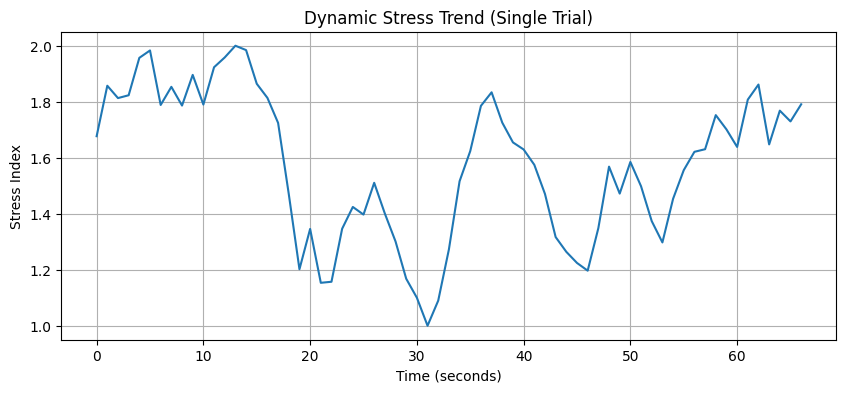

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(stress_series)
plt.title("Dynamic Stress Trend (Single Trial)")
plt.xlabel("Time (seconds)")
plt.ylabel("Stress Index")
plt.grid(True)
plt.show()


In [47]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import numpy as np


In [48]:
groups = []

for (sid, vid), _ in eeg_df.groupby(["SubjectID", "VideoID"]):
    groups.append(sid)

groups = np.array(groups)


In [49]:
gkf = GroupKFold(n_splits=5)

accs = []
aucs = []

for train_idx, test_idx in gkf.split(X, y, groups):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_te = scaler.transform(X_te)

    clf = SVC(kernel="rbf", C=10, gamma="scale", probability=True)
    clf.fit(X_tr, y_tr)

    y_pred = clf.predict(X_te)
    y_prob = clf.predict_proba(X_te)[:, 1]

    accs.append(accuracy_score(y_te, y_pred))
    aucs.append(roc_auc_score(y_te, y_prob))

print("CV Accuracy:", np.mean(accs))
print("CV AUC:", np.mean(aucs))


CV Accuracy: 0.5
CV AUC: 0.47800000000000004


In [56]:
y = y.astype(int)

np.bincount(y)


array([50, 50])

In [52]:
clf = SVC(
    kernel="rbf",
    C=10,
    gamma="scale",
    class_weight="balanced",
    probability=True
)


In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_te, y_pred))


              precision    recall  f1-score   support

         0.0       0.56      0.50      0.53        10
         1.0       0.55      0.60      0.57        10

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20



In [54]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_tr, y_tr)
y_pred = rf.predict(X_te)


In [57]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_te, y_pred)
print("Random Forest Accuracy:", acc)


Random Forest Accuracy: 0.6


In [58]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[5 5]
 [3 7]]


In [59]:
from sklearn.metrics import classification_report

print(classification_report(y_te, y_pred))


              precision    recall  f1-score   support

         0.0       0.62      0.50      0.56        10
         1.0       0.58      0.70      0.64        10

    accuracy                           0.60        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.60      0.60      0.60        20



In [60]:
from sklearn.metrics import roc_auc_score

y_prob = rf.predict_proba(X_te)[:, 1]
auc = roc_auc_score(y_te, y_prob)

print("Random Forest ROC-AUC:", auc)


Random Forest ROC-AUC: 0.7100000000000001


In [61]:
FEATURE_ORDER += [
    "theta_median",
    "beta_median",
    "signal_energy",
    "theta_rel",
    "beta_rel",
]


In [62]:
y = y.astype(int)


In [63]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500,     # was 300
    max_depth=6,          # was 5
    min_samples_leaf=2,   # reduces overfitting
    class_weight="balanced",
    random_state=42
)


In [64]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import numpy as np

gkf = GroupKFold(n_splits=5)
accs, aucs = [], []

for train_idx, test_idx in gkf.split(X, y, groups):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    rf.fit(X_tr, y_tr)
    y_pred = rf.predict(X_te)
    y_prob = rf.predict_proba(X_te)[:, 1]

    accs.append(accuracy_score(y_te, y_pred))
    aucs.append(roc_auc_score(y_te, y_prob))

print("CV Accuracy:", np.mean(accs))
print("CV ROC-AUC:", np.mean(aucs))


CV Accuracy: 0.59
CV ROC-AUC: 0.672


In [65]:
from sklearn.calibration import CalibratedClassifierCV

rf_cal = CalibratedClassifierCV(rf, method="isotonic", cv=3)
rf_cal.fit(X_tr, y_tr)
y_prob = rf_cal.predict_proba(X_te)[:, 1]
